# A/B Testing

## Objective: 

Many product-focused companies rely on quick user feedback on experimental product changes to remain relevant and to maintain a moat with their competitors. In order to get that feedback quickly in a cost-effective way, an experiment is performed on a sample of the whole population/user base. 

A test is designed to measure performance of the current state of the product and an alternative state of the product to see if a change in the product would be beneficial to users or not.

This notebook will cover the process of analyzing an A/B test from formulating the hypothesis, testing it, all the way to interpreting the results.

## Scenario

Currently embedded in Product team at medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, team would be more comfortable testing it on a small number of users to see how it performs. So I suggest running an A/B test on a subset of the user base.

## Data

Kaggle dataset which contains A/B test results from 2 different website page designs (default/new)

## 1. Designing Experiment

### Formulating Hypothesis

* Make sure to formulate at start of experiment. This is so:

    * test is rigorous
    * results are sound
    
* not sure if new feature will be worse or better so will have two-tailed test:

$$H_0: p = p_0$$
$$H_a: p \neq p_0$$

where $p$ and $p_0$ stand for the conversion rate of the new and old design

* setting 95% Confidence Interval:

$$\alpha = 0.05$$

$\alpha$ is threshold we set as our risk tolerance for maximum probability of incorrectly rejecting $H_0$
Another way of defining it is: "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis"

Since our $\alpha$ = 0.05 (indicating 5% probability), our confidence (1 - $\alpha$) = 95%

In simpler terms, what this means is that we want to be 95% confident that new product feature's conversion rate is statistically significant before we reject $H_0$.

### Choosing Variables

For the test, we'll need two groups:
* `control` - shown current design
* `test` - shown experimental design

The test groups will be our _Independent Variable_. Despite knowing baseline conversion rate, we have two groups because we want to control for other variables that could have an effect on our results, such as seasonality. By having a `control` group, we can directly compare their results to the `treatment` group. The only systematic difference between the groups would be the product page's design. So we can attribute any differences in results to that.

Our _Dependent Variable_ aka what we are measuring in each group and interested in capturing is the `conversion rate`. The way we will be defined in the data is with a binary variable:

* `0` - The user did not buy the product during a session
* `1` - The user did buy the product during a session

Conversion rate mean can then be calculated per group/design.

### Choosing the Sample Size

Due to the monetary and time costs associated with testing the whole user base/population, we take a sample and measure conversion rates. Thus, measurements will only be _estimates_ of the true rates.

Number of people/user sessions we decide to capture in each group will directly affect the precision of our estimated conversion rates: larger the sample size, more precise the estimates (i.e. smaller our confidence intervals), higher the chance to detect difference, if present, in two groups.

At the same time, larger the sample size, more expensive and impractical the study becomes.

_Thus, how many people do we need to have in each group?_

Turns out that the sample size we need is determined by a _Power Analysis_. It depends on a few factors:

* Power of the test () - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on [statistical power](https://en.wikipedia.org/wiki/Power_of_a_test), if you are curious)
* Alpha value () - The critical value we set earlier to 0.05
* Effect size - How big of a difference we expect there to be between the conversion rates

Team would be happy with 2% lift. So we will use 13% and 15% to calculate the effect size.

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [2]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


Based on the above calculation, looks like we will need at minimum **4720** observations in each group.

And having set the `power` parameter to 0.80 in practice means that if there exists an actual difference in conversion rate between our designs, assuming difference is going to be one estimated (2% lift), we have approximately 80% chance to detect it as statistically significant in our test with the sample size we calculated. 

## 2. Collecting and Preparing the Data

Usually at this point, you would work with your team to set up the experiment, likely with the help of the Engineering team. Or if your company has A/B test tooling like Launch Darkly or Optimizely, you can just have the PM set up the flags and you wait for the numbers to come in.

For now, we'll use our Kaggle sample dataset, perform any necessary pre-processing and randomly select our 4720 users/sessions.

In [3]:
df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# To make sure the control group is only seeing the old page and vice versa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are `294478` rows in the dataframe each representing a user session along with 5 columns.

* `user_id` - The user ID of each session
* `timestamp` - Timestamp for the session
* `group` - Which group the user was assigned to for that session {control, treatment}
* `landing_page` - Which design each user saw on that session {old_page, new_page}
* `converted` - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

Although this was given to us, for our purposes we will use `group` and `converted` for our analysis.

In [6]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [7]:
print('There are duplicate users in the dataset. They make up',  3894/df.shape[0], 'of the dataset. This is a low percentage so we can just take them out.')

There are duplicate users in the dataset. They make up 0.013223398691922657 of the dataset. This is a low percentage so we can just take them out.


In [8]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries.')

The updated dataset now has 286690 entries.


### Sampling

Now that our Dataframe is nice and clean, we can proceed to sample `n=4720` entries for each of the groups. Pandas' `DataFrame.sample()` method helps us achieve this because it performs a Simple Random Sampling for us.

Note: Using `random_state=22` allows reproducible results. So if sampling is done again using this parameter, results we get will be the same as first time ran.

In [9]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [10]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [11]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [12]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

Great, the sampling number per group is as expected.

## 3. Visualizing the Results

Let's do some simple stat calculations to see what our samples look like.

In [13]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


We can see that between control and treatment, conversion rates are similar, but new design performed slightly better: **12.6% vs. 12.3% conversion rate**.

Plotting the rates will make it easier and faster to digest these results.

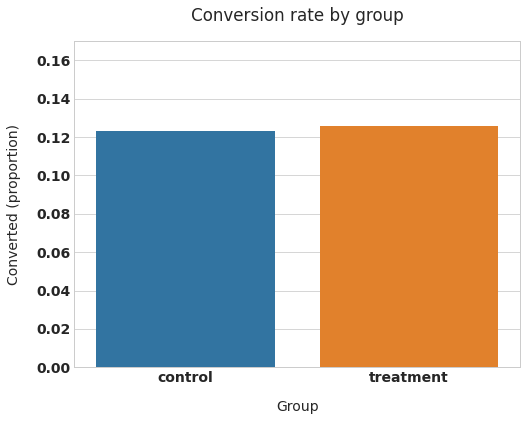

In [14]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

We can see that the conversion rates are very close. Also, note that the conversion for the `control` group is lower than what we would have expected given we our average conversion has been **13%**. This proves that there can be some variation in our results when we sample from our variation.

At this point, we see that the treatment has a lift from the control group, but is this difference **statistically signiicant**?

__________

## 4. Testing the Hypothesis

The last step of our analysis is to test our hypothesis. We have a very large sample so we can use the [normal approximation](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval) for calculating our *p-value* (i.e. z-test).

We can use `statsmodels.stats.proportion` module to get the p-value and confidence intervals:

In [15]:
#import stats library
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [16]:
#get the target metric column
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [17]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


_______

## 5. Conclusion and Recommendation

Our **p-value** is way above our $\alpha$ = 0.05. So we cannot reject our $H_0$. This means our new design did not perform statistically different than our current/old design.

Additionally, if we look at the confidence interval for the `treatment` group: ([0.116, 0.135], 11.6% - 13.5%) we notice:

1. It includes our baseline conversion rate of 13%
2. It does not include our target value of 15% (the 2% lift in conversion rate we were aiming for)

What this means is that the true conversion rate of the new design is more likely closer to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be a improvement on our old design. And that unfortunately means we are back to the drawing board, but still had good learnings!